In [10]:
#@title Configuration. Edit this before running the rest.

OUTPUT_DIR='output'
RUN_ID='default-run'
# Path to the benchmark dir under `gateway-api-inference-extension/benchmark`
BENCHMARK_DIR ="./"
# A regex to match the output file name.
FILE_MATCHER='.*stage_\d_lifecycle_metrics*'
INTERACTIVE_PLOT='False'

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2612482/2189011373.py:8: SyntaxWarning: invalid escape sequence '\d'
  FILE_MATCHER='.*stage_\d_lifecycle_metrics*'


In [11]:
#@title Plot Helper
import os
import pandas as pd
import re
import json
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import r2_score
import logging
level = logging.INFO
logger = logging.getLogger(__name__)
logger.setLevel(level)
handler = logging.StreamHandler()  # This sends output to the console
handler.setLevel(level) # Set handler level
logger.addHandler(handler)

title_fontsize = 18
axis_label_fontsize = 18
legend_fontsize = 16
tick_label_fontsize = 14

# Encapsulates some basic information needed to plot metrics.
class XY:
  def __init__(self, x: str, y: str, x_label=None, y_label=None):
    self.x = x
    self.y = y
    self.x_label = x if x_label is None else x_label
    self.y_label = y if y_label is None else y_label

NUM_PLOTS_PER_ROW = 4
# The arguments need to match the metric name fields generated by the benchmark tool.
CORE_METRICS = [
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'successes_throughput_output_tokens_per_sec', y_label= 'output_tokens_per_sec'),
    XY(x = "load_summary_requested_rate", x_label = 'QPS', y = "successes_latency_time_per_output_token_p90", y_label= 'p90_per_output_token_latency'),
    XY(x = "load_summary_requested_rate", x_label = 'QPS', y = "successes_latency_request_latency_p90", y_label= 'p90_latency'),
    XY(x = "load_summary_requested_rate", x_label = 'QPS', y = "load_summary_count", y_label= 'num_prompts_attempted'),
    XY(x = "load_summary_requested_rate", x_label = 'QPS', y = "successes_count", y_label= 'num_prompts_succeeded'),
]
SANITY_CHECK_METRICS = [
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'successes_throughput_requests_per_sec', y_label= 'throughput_rps'),
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'successes_throughput_input_tokens_per_sec', y_label= 'total_input_tokens'),
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'successes_throughput_output_tokens_per_sec', y_label= 'total_output_token'),
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'prompt_len_mean', y_label= 'avg_input_len'),
    XY(x = 'load_summary_requested_rate', x_label = 'QPS', y = 'output_len_mean', y_label= 'avg_output_len'),
]

class Label:
  def __init__(self, name, alias=None):
    self.name = name
    self.alias = name if alias is None else alias

ALL_METRICS = CORE_METRICS  + SANITY_CHECK_METRICS

class Plotter:
  def __init__(self, run_id, labels=None, metrics=CORE_METRICS, num_plots_per_row=5, interactive=False, annotate=False, output_dir=OUTPUT_DIR):
    self.run_id = run_id
    self.labels = labels
    self.metrics = metrics
    self.num_plots_per_row = num_plots_per_row
    self.interactive = interactive
    self.annotate = annotate
    self.output_dir = output_dir
    self.data = load_data(self.labels, self.run_id, self.output_dir)
    self.groups = group_data(self.data, self.metrics)

  def withRunId(self, run_id):
    return Plotter(run_id, self.labels, self.metrics, self.num_plots_per_row, self.interactive, self.annotate, self.output_dir)

  def withLabels(self, labels):
    return Plotter(self.run_id, labels, self.metrics, self.num_plots_per_row, self.interactive, self.annotate, self.output_dir)

  def withMetrics(self, metrics):
    return Plotter(self.run_id, self.labels, metrics, self.num_plots_per_row, self.interactive, self.annotate, self.output_dir)

  def withOutputDir(self, output_dir):
    return Plotter(self.run_id, self.labels, self.metrics, self.num_plots_per_row, self.interactive, self.annotate, output_dir)

  def plot_bar(self):
    
    logger.debug("Plotting run id...")
    plot_bar(self.labels, self.groups, self.metrics, self.num_plots_per_row, self.interactive, annotate=self.annotate)

  def plot_delta(self):
    """
    Plot the delta between two labels.
    """
    logger.debug("Plotting delta for run id...")
    plot_delta(self.labels, self.groups, self.metrics, self.num_plots_per_row, self.interactive, annotate=self.annotate)

def filepaths(root_dir):
    """
    Recursively reads files within a directory and returns a list of file paths.
    """

    filepaths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            filepaths.append(filepath)
    return filepaths

def flatten_server_metrics(server_metrics):
  """
  Flattens the server metrics json to a single level.
  """
  flattend = {}
  for k, v in server_metrics.items():
    if isinstance(v, dict):
      for k2, v2 in v.items():
        flattend[k + "." + k2] = v2

  return flattend

def load_data(labels, run_id, output_dir=OUTPUT_DIR):
  data_path =f"{BENCHMARK_DIR}/{output_dir}/{run_id}"
  records = []
  logger.debug(f"Loading data for {data_path}")
  for file in filepaths(data_path):
    for label in labels:
      regex = f".*/{label.name}/results/json/{FILE_MATCHER}.json"
      logger.debug(f"matching file {file} for regex {regex} and label {label}")
      if re.match(regex, file):
        logger.debug(f"found match file {file} for regex {regex} and label {label}")
        with open(file, 'r') as f:
          raw_data = json.load(f)
          sample_data = {
              'file_name': f.name,
              'label': label.alias,
          }
          for k, v in raw_data.items():
            if isinstance(v, dict):
              for k2, v2 in v.items():
                if isinstance(v2, dict):
                  for k3, v3 in v2.items():
                    if isinstance(v3, dict):
                      for k4, v4 in v3.items():
                        sample_data[f"{k}_{k2}_{k3}_{k4}"] = v4
                    else:
                      sample_data[f"{k}_{k2}_{k3}"] = v3
                else:
                    sample_data[f"{k}_{k2}"] = v2
            else:
                sample_data[k] = v
          if 'config_load_summary_requested_rate' in sample_data and 'config_num_models' in sample_data:
              sample_data['load_summary_requested_rate'] = sample_data['config_load_summary_requested_rate'] * sample_data['config_num_models']
          records.append(sample_data)
  all_data = pd.DataFrame.from_records(records, index='file_name') if len(records) > 0 else pd.DataFrame()
  return all_data

def group_data(all_data, metrics=CORE_METRICS):
  try:
    data = all_data.sort_values(by=['load_summary_requested_rate'], ascending=True).copy()
  except Exception as e:
    print(f"Error sorting data: {e}")
    return None

  # Ensure there is exactly one benchmark result per label and x-axis for each
  # metric.
  x_axes = set()
  for m in metrics:
    x_axes.add(m.x)

  for x in x_axes:
    # Check for missing columns before grouping
    if 'label' not in data.columns or x not in data.columns:
        print(f"Missing 'label' or '{x}' column in data, skipping grouping.")
        continue
    sizes = data.groupby(by=['label', x], dropna=True).size()
    for index, v in sizes.items():
      if v > 1:
        label, _ = index
        # print(f"Multiple benchmark results for the same label ({label}), and x-axis ({x}). {index}: {v}. Please use more selective file filters.")
        # raise ValueError(f"Multiple benchmark results for the same label ({label}), and x-axis ({x}). Please use more selective file filters.")

  # Group by label.
  if 'label' in data.columns:
    groups = data.groupby(by=['label'],sort=True)
    return groups
  else:
    print("Missing 'label' column, cannot group data.")
    return None

def compute_r2_for_metrics(groups, metrics, label_before, label_after):
    print("\nCoefficient of Determination (R^2) between before and after runs:")
    for m in metrics:
        try:
            df_b = groups.get_group(label_before).set_index('load_summary_requested_rate')
            df_a = groups.get_group(label_after).set_index('load_summary_requested_rate')
        except KeyError:
            print(f"  Skipping {m.y}: missing group data for '{label_before}' or '{label_after}'")
            continue
        common = sorted(set(df_b.index).intersection(df_a.index))
        yb = df_b.loc[common, m.y].values
        ya = df_a.loc[common, m.y].values
        mask = ~np.isnan(yb) & ~np.isnan(ya)
        yb, ya = yb[mask], ya[mask]
        if len(yb) > 1 and np.any(yb != 0):
            r2 = r2_score(yb, ya)
            print(f"  {m.y:<30} R^2 = {r2:.4f}")
        else:
            print(f"  {m.y:<30} insufficient data for R^2 calculation")


def init_plot(metrics, num_plots_per_row=NUM_PLOTS_PER_ROW):
  num_plots_per_row = min(num_plots_per_row, len(metrics))
  row_count = math.ceil(len(metrics) / num_plots_per_row)
  fig, axes = plt.subplots(nrows=row_count, ncols=num_plots_per_row, figsize=(20, 5*row_count), tight_layout=True)
  if row_count == 1 and num_plots_per_row == 1:
    axes = [axes]
  return fig, axes

def plot_metrics(metrics, plot_func, num_plots_per_row=NUM_PLOTS_PER_ROW, fig=None, axes=None):
  """
  plot_func: a function in the form of def plot_func(ax:~matplotlib.axes.Axes , m: XY):
  """
  logger.debug(f'Plotting metrics: {metrics}')
  num_plots_per_row = min(num_plots_per_row, len(metrics))
  if fig is None or axes is None:
    logger.debug(f'Creating new figure and axes')
    fig, axes = init_plot(metrics, num_plots_per_row)
  row_count = math.ceil(len(metrics) / num_plots_per_row)
  for i, m in enumerate(metrics):
    row = math.floor(i/num_plots_per_row)
    col = i%num_plots_per_row
    if row_count == 1:
      curAx = axes[col]
    else:
      curAx = axes[row, col]
    plot_func(curAx, m)
  return fig, axes

def plot_bar(labels, groups, metrics=CORE_METRICS, num_plots_per_row=NUM_PLOTS_PER_ROW, interactive=INTERACTIVE_PLOT, annotate=False):
    labels = [label.alias for label in labels]
    logger.debug(f'Prnting bar chart for {labels}')
    logger.debug(f'groups: {groups}')
    dataframes = []
    for label in labels:
      try:
        dataframes.append(groups.get_group((label,)))
      except:
        logger.debug(f"No data found for label {label}")
        continue
    y_columns = [m.y for m in metrics]
    logger.debug(f'y_columns: {y_columns}')
    logger.debug(f'dataframes: {dataframes}')

    # 1. Combine all request rates
    all_load_summary_requested_rates = set()
    for df in dataframes:
        all_load_summary_requested_rates.update(df['load_summary_requested_rate'].astype(int))
    all_load_summary_requested_rates = sorted(list(all_load_summary_requested_rates))

    # 2. Prepare data for plotting:  Create a nested dictionary
    plot_data = {y_col: {label: {} for label in labels} for y_col in y_columns}

    for i, df in enumerate(dataframes):
        label = labels[i]
        df_dict = df.set_index('load_summary_requested_rate').to_dict()
        for y_col in y_columns:
            for load_summary_requested_rate in all_load_summary_requested_rates:
                plot_data[y_col][label][load_summary_requested_rate] = df_dict.get(y_col, {}).get(load_summary_requested_rate, np.nan)

    logger.debug(f'Plot_data: {plot_data}')

    # 3. Plotting
    def plot_func(curAx, m):
      num_load_summary_requested_rates = len(all_load_summary_requested_rates)
      num_labels = len(labels)
      x = np.arange(num_load_summary_requested_rates)  # the label locations (x-axis positions)
      width = 0.4 / num_labels   # width of the bars

      for i, label in enumerate(labels):
          bar_x = x - (width*num_labels)/2 + i*width + width/2
          #Extract y-values to plot
          y_values = [plot_data[m.y][label][rr] for rr in all_load_summary_requested_rates]

          rects = curAx.bar(bar_x, y_values, width, label=label)
          if annotate:
            for rect, val in zip(rects, y_values):
                if not np.isnan(val):
                    height = rect.get_height()
                    curAx.annotate(f'{val:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
      # Add labels, title, and legend
      curAx.set_xlabel(m.x_label, fontsize=axis_label_fontsize)
      curAx.set_ylabel(m.y_label, fontsize=axis_label_fontsize)
      curAx.set_xticks(x)
      curAx.set_xticklabels(all_load_summary_requested_rates)
      curAx.tick_params(axis='both', labelsize=tick_label_fontsize)
      curAx.legend(fontsize=legend_fontsize, loc='upper left', frameon=True, framealpha=0.8, edgecolor='black')
    fig, axes = plot_metrics(metrics, plot_func, num_plots_per_row)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_delta(labels, groups, metrics=CORE_METRICS, num_plots_per_row=NUM_PLOTS_PER_ROW, interactive=True, annotate=False):
    """
    Plot the delta between base_label and compare_label for each metric.
    A positive delta means compare_label has a higher value than base_label.
    """
    base_label = labels[0].name
    compare_label = labels[1].name
    logger.debug(f'Printing delta chart for {base_label} vs {compare_label}')

    try:
        base_df = groups.get_group((base_label,))
        compare_df = groups.get_group((compare_label,))
    except Exception as e:
        logger.error(f"Error getting data for labels {base_label} and {compare_label}: {e}")
        return

    y_columns = [m.y for m in metrics]

    # 1. Find common request rates
    base_rates = set(base_df['load_summary_requested_rate'].astype(int))
    compare_rates = set(compare_df['load_summary_requested_rate'].astype(int))
    common_rates = sorted(list(base_rates.intersection(compare_rates)))[:6]

    if not common_rates:
        logger.error(f"No common request rates found between {base_label} and {compare_label}")
        return

    # 2. Prepare data for delta calculation
    base_data = base_df.set_index('load_summary_requested_rate').to_dict()
    compare_data = compare_df.set_index('load_summary_requested_rate').to_dict()

    # Calculate deltas (compare_label - base_label)
    delta_data = {y_col: {} for y_col in y_columns}
    for y_col in y_columns:
        for rate in common_rates:
            base_val = base_data.get(y_col, {}).get(rate, np.nan)
            compare_val = compare_data.get(y_col, {}).get(rate, np.nan)

            if not np.isnan(base_val) and not np.isnan(compare_val):
                delta_data[y_col][rate] = (compare_val - base_val)/base_val*100
            else:
                delta_data[y_col][rate] = np.nan

    # 3. Plotting
    def plot_func(curAx, m):
        x = np.arange(len(common_rates))
        y_values = [delta_data[m.y].get(rr, np.nan) for rr in common_rates]

        # Determine colors based on positive/negative values
        colors = ['green' if val > 0 else 'blue' for val in y_values]

        rects = curAx.bar(x, y_values, 0.6, color=colors)

        # Add a horizontal line at y=0
        curAx.axhline(y=0, color='black', linestyle='-', linewidth=1)

        if annotate:
            for rect, val in zip(rects, y_values):
                if not np.isnan(val):
                    height = rect.get_height()
                    # For negative bars, put text above the bar
                    vert_align = 'bottom' if val >= 0 else 'top'
                    y_offset = 3 if val >= 0 else -3

                    curAx.annotate(f'{val:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, val),
                            xytext=(0, y_offset),  # vertical offset
                            textcoords="offset points",
                            ha='center', va=vert_align)

        # Create a title that shows what this delta represents
        title = f"Delta: {compare_label} - {base_label} ({m.y})"
        curAx.set_title(title, fontsize=12)

        # Add labels
        curAx.set_xlabel(m.x_label, fontsize=axis_label_fontsize)
        #curAx.set_ylabel(f"% Delta in {m.y_label}", fontsize=axis_label_fontsize)
        curAx.set_xticks(x)
        curAx.set_xticklabels(common_rates)
        curAx.tick_params(axis='both', labelsize=tick_label_fontsize)

        # Create a dummy handle for the legend
        legend_handle = [plt.Rectangle((0,0),1,1,color='green'),
                        plt.Rectangle((0,0),1,1,color='blue')]
        legend_label = [f'{compare_label} > {base_label}',
                       f'{compare_label} < {base_label}']

        return legend_handle, legend_label

    # Create plot with metrics
    fig, axes = plot_metrics(metrics, plot_func, num_plots_per_row)

    # Add an overall title for the figure
    fig.suptitle(f"% Delta Metrics: {compare_label} - {base_label}",
                fontsize=title_fontsize, y=0.98)

    plt.subplots_adjust(bottom=0.15, top=0.9)  # Make room for legends
    fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust the rectangle in which the subplots fit
    plt.show()

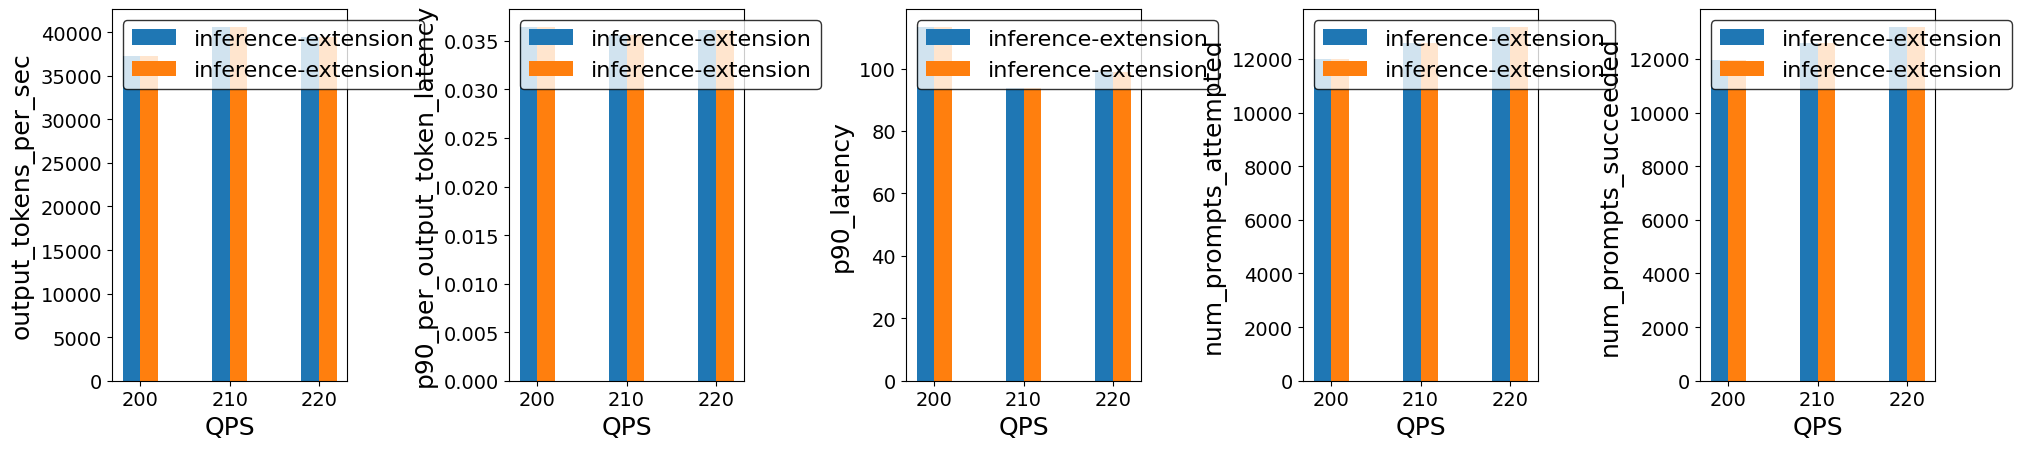

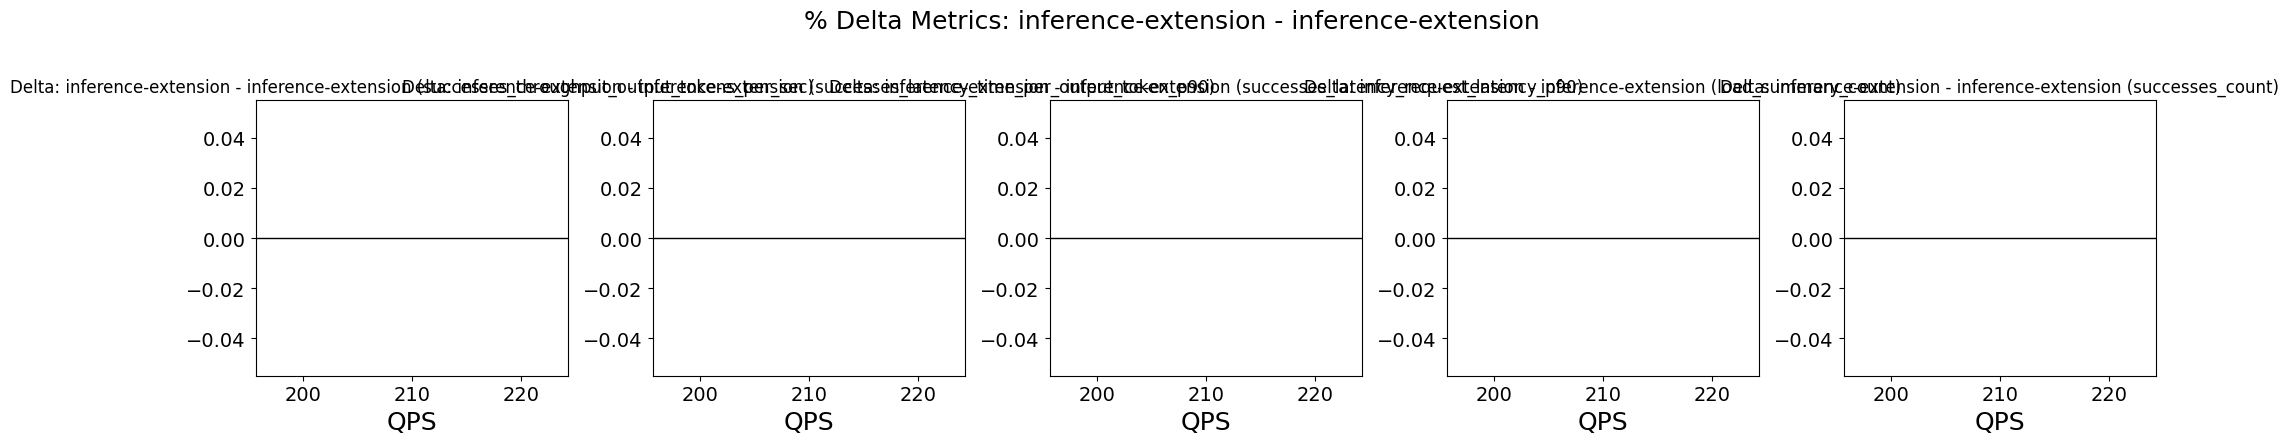


Coefficient of Determination (R^2) between before and after runs:
  successes_throughput_output_tokens_per_sec R^2 = 1.0000
  successes_latency_time_per_output_token_p90 R^2 = 1.0000
  successes_latency_request_latency_p90 R^2 = 1.0000
  load_summary_count             R^2 = 1.0000
  successes_count                R^2 = 1.0000


/tmp/ipykernel_2612482/1457368969.py:189: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_b = groups.get_group(label_before).set_index('load_summary_requested_rate')
/tmp/ipykernel_2612482/1457368969.py:190: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_a = groups.get_group(label_after).set_index('load_summary_requested_rate')
/tmp/ipykernel_2612482/1457368969.py:189: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_b = groups.get_group(label_before).set_index('load_summary_requested_rate')
/tmp/ipykernel_2612482/1457368969.py:190:

In [12]:
#@title Plot Result
# initialize the plotter with the run id and labels. 
# Example labels are 'inference-extension' and 'k8s-svc' if comparing Inference Extension and K8s Service 
# 'regression-before' and 'regression-after' if comparing two different runs of inference extension to see the regression

benchmark_id1 =  'inference-extension' # eg 'regression-before' or 'inference-extension'
benchmark_id2 = 'inference-extension' # eg 'regression-after' or 'k8s-svc'
labels = [Label(benchmark_id1), Label(benchmark_id2,)]

# Plot bar chart of metrics
pl = Plotter(run_id=RUN_ID, labels=labels, output_dir=OUTPUT_DIR)
pl.plot_bar()
pl.plot_delta()

# Load & group data to compute R^2
all_data = load_data(labels, RUN_ID, OUTPUT_DIR)
groups = group_data(all_data)
compute_r2_for_metrics(groups, CORE_METRICS,
                           label_before=benchmark_id1,
                           label_after=benchmark_id2)

